In [10]:
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

# https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877


In [118]:
# Import data
data = pd.read_csv('data/bydaym2.csv')
data.head()


In [119]:
data = data.query('stock=="삼성전자"')
print(data.head())


In [121]:
# query
data_s = data.query('date>=20170403 & date<=20180403')
print(data.head())

In [122]:
# Drop date variable
# data_s = data_s.drop(['stock','date'], 1)
data_s = data_s.drop(['stock','date','diff','vol','f','i'], 1)


In [123]:
print(data_s)


In [124]:
plt.plot(data_s['close'])

In [125]:
# Dimensions of dataset
n = data_s.shape[0]
p = data_s.shape[1]
# Make data a numpy array
data_s = data_s.values


In [126]:
print(n)
print(p)


In [162]:
# training data contained 80% of the total dataset
train_start = 0
train_end = int(np.floor(0.7*n))
test_start = train_end
test_end = n
data_train = data_s[np.arange(train_start, train_end), :]
data_test = data_s[np.arange(test_start, test_end), :]

In [164]:
# Scale data(RELu) common 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [130]:
print(X_train)
print(y_train)
print(X_test) 
print(y_test)


In [165]:
# Import TensorFlow
import tensorflow as tf

# Define a and b as placeholders
a = tf.placeholder(dtype=tf.int8)
b = tf.placeholder(dtype=tf.int8)

# Define the addition
c = tf.add(a, b)

# Initialize the graph
graph = tf.Session()

# Run the graph
graph.run(c, feed_dict={a: 5, b: 4})


In [166]:

# Initializers
#initialize the network’s variables before training. 
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

0.04945215


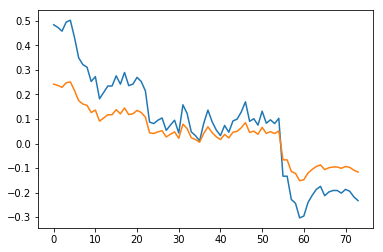

In [188]:
# Model architecture parameters
n_period = 3
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1024
# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_period, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))



0.04945215


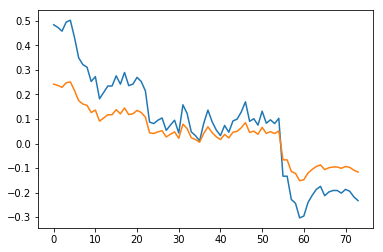

In [189]:
# t    t+1
# [None, n_period] with [None] meaning that the inputs are a 
# 2-dimensional matrix and the outputs are a 1-dimensional vector

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_period])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

#None argument indicates that at this point we do not yet know the number of 
# observations that flow through the neural net graph in each batch, 



0.04945215


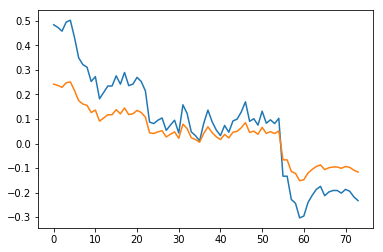

In [190]:

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))


0.04945215


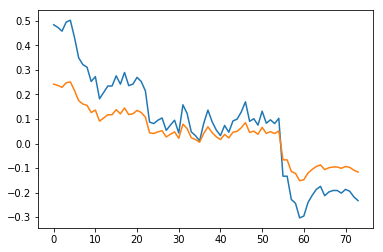

In [191]:
#deviation between the network’s predictions and the actual observed training targets. 
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))


0.04945215


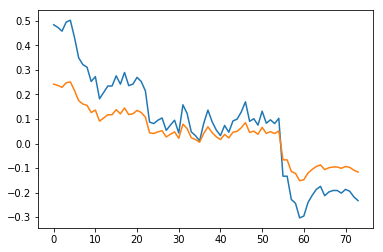

In [192]:
# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)




0.04945215


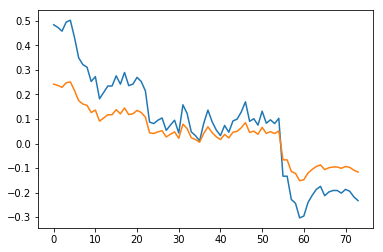

In [196]:
#laceholders, variables, initializers, cost functions and optimizers of the network, 
# the model needs to be trained

#  sampled data batch of X flows through the network until it reaches the output layer. There, TensorFlow compares 
# the models predictions against the actual observed targets Y in the current batch.

# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
# plt.show()

# Number of epochs and batch size
epochs = 1000
batch_size = 512

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 5) == 0:
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            plt.savefig(file_name)
            plt.pause(0.01)
# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)